In [8]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.utils import multi_gpu_model 
from keras.utils import to_categorical


Read the data
===========

In [9]:
x_original=pd.read_csv('../../_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('../../_targelable4_withNa_AllColumns.txt')

x_original=x_original[['Unnamed: 0','S000300', 'SEX', 'L103300', 'S000501', 
                       'L103100', 'L101300', 'S000502', 'L190300', 'L190400', 'L100700', 'L103000', 'L100800',
                      'FIELD_16','FIELD_23','FIELD_15','FIELD_22','FIELD_17','FIELD_24']]

y_original=y_original[['Unnamed: 0','S000300']]

print(x_original.shape)
print(y_original.shape)


(159381, 19)
(159381, 2)


Prepare the data
============

In [10]:
data= pd.merge(x_original,y_original, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data=data.dropna(). reset_index()

print(data.shape)

(128409, 21)


In [11]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia
print(data.shape)

(128409, 21)


In [12]:
print(data.shape)
print(data.columns)
data.head()

(128409, 21)
Index(['index', 'Unnamed: 0', 'S000300_x', 'SEX', 'L103300', 'S000501',
       'L103100', 'L101300', 'S000502', 'L190300', 'L190400', 'L100700',
       'L103000', 'L100800', 'FIELD_16', 'FIELD_23', 'FIELD_15', 'FIELD_22',
       'FIELD_17', 'FIELD_24', 'S000300_y'],
      dtype='object')


,index,Unnamed: 0,S000300_x,SEX,L103300,S000501,L103100,L101300,S000502,L190300,...,L100700,L103000,L100800,FIELD_16,FIELD_23,FIELD_15,FIELD_22,FIELD_17,FIELD_24,S000300_y
0,0,0,20.1,1.0,3.1,121.0,68.0,8.0,67.0,4.20,...,3.0,53.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,19.7
1,1,1,19.7,1.0,3.3,117.0,71.0,9.0,76.0,4.24,...,3.0,53.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,20.2
2,2,2,20.2,1.0,3.4,135.0,72.0,10.0,82.0,4.26,...,3.8,41.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0
3,3,3,24.8,1.0,2.8,118.0,64.0,12.0,71.0,4.20,...,3.7,58.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,25.5
4,4,4,25.5,1.0,2.9,111.0,58.0,12.0,65.0,3.92,...,3.4,50.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,25.4


In [28]:

x=data[['Unnamed: 0','S000300_x', 'SEX', 'L103300', 'S000501', 
                       'L103100', 'L101300', 'S000502', 'L190300', 'L190400', 'L100700', 'L103000', 'L100800']]

y=data[['Unnamed: 0','S000300_y']]


Check the correlation of the selected feature with the independent variables
=====

In [29]:
temppd=pd.DataFrame(x.copy())
temppd['y']=y.S000300_y
temppd.head()
corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

In [30]:
corval.y

y             1.000000
S000300_x     0.884348
L103300       0.422281
S000501       0.407849
L100700       0.401326
SEX           0.378691
L103100       0.358006
L190300       0.357028
L190400       0.349019
L101300       0.337227
S000502       0.331693
L103000       0.324958
L100800       0.271994
Unnamed: 0    0.025452
Name: y, dtype: float64

Apply PCA
===========

In [31]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [32]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [33]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [34]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

In [35]:
# x.columns

Random Forest Regressor
=============

In [36]:
ylable=y[['S000300_y']]  
xtrain,xtest,ytrain,ytest=train_test_split(x, ylable, random_state=42, test_size=0.2)

In [37]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=500)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[6.07923800e-02 8.92088448e-01 6.91034900e-06 1.51581590e-04
 3.07584331e-03 4.52236021e-04 2.76134770e-03 1.88696666e-02
 4.34037105e-03 4.45879632e-04 7.73810557e-03 2.14318139e-03
 7.13404925e-03]


mean_squared_error 2.162546542699557
root mean_squared_error 1.4705599418927326
mean_absolute_error 0.6843403761207573
r2_score 0.7943854204990306


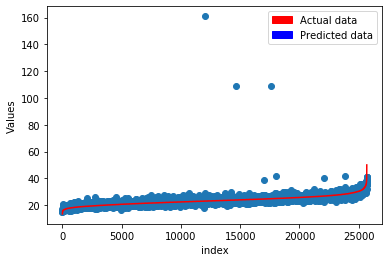

,t + 1,pred (t +1)
13423,38.7,36.569480
12671,38.8,36.342572
533,39.0,37.335764
22763,39.4,39.506383
19389,40.4,39.462536
22159,40.8,38.281829
4397,42.7,37.893543
14024,45.4,40.854270
3321,48.3,41.017514
6565,50.0,40.787114


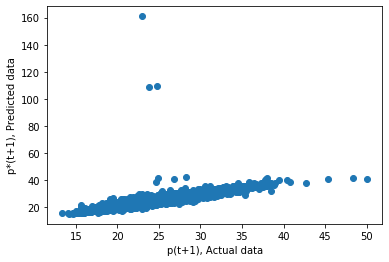

In [38]:

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

In [39]:
# tempdata=pd.DataFrame(xtest.copy())
# tempdata['ytest']=ytest
# # temp=temp.dropna()
# # tempdata.head()
# # tempdata[tempdata.ytest.isna()].index

# tempdata=tempdata.drop(tempdata[tempdata.ytest.isna()].index)


xg boost
==========

In [25]:
import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# import pandas as pd
# import numpy as np

In [26]:
xg_reg = xgb.XGBRegressor()
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(xtrain, ytrain) 

[19:28:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [27]:

ypred = xg_reg.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

# ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
# ypredPD['t + 1']=ytest.values
# ypredPD['pred (t +1)']=ypred
# ypredPD.head(10)

mean_squared_error 0.8578194915729614
root mean_squared_error 0.9261854520413076
mean_absolute_error 0.6715202587841549
r2_score 0.9184386599017054


In [23]:
# ytest[ytest.isna()].shape
# tempdata.iloc[:,-1]

ANN
==========

In [58]:
model= Sequential()
model.add(Dense(input_dim=29,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [59]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

Train on 23032 samples, validate on 5759 samples
Epoch 1/100
23032/23032 [==============================] - 3s 120us/step - loss: 118.7340 - mean_squared_error: 118.7340 - val_loss: 19.8389 - val_mean_squared_error: 19.8389
Epoch 2/100
23032/23032 [==============================] - 1s 51us/step - loss: 25.9030 - mean_squared_error: 25.9030 - val_loss: 10.8667 - val_mean_squared_error: 10.8667
Epoch 3/100
23032/23032 [==============================] - 1s 51us/step - loss: 22.3034 - mean_squared_error: 22.3034 - val_loss: 10.7477 - val_mean_squared_error: 10.7477
Epoch 4/100
23032/23032 [==============================] - 1s 51us/step - loss: 20.5817 - mean_squared_error: 20.5817 - val_loss: 10.7501 - val_mean_squared_error: 10.7501
Epoch 5/100
23032/23032 [==============================] - 1s 50us/step - loss: 18.8789 - mean_squared_error: 18.8789 - val_loss: 11.0220 - val_mean_squared_error: 11.0220
Epoch 6/100
23032/23032 [==============================] - 1s 51us/step - loss: 17.3384 

Epoch 49/100
23032/23032 [==============================] - 1s 50us/step - loss: 9.1582 - mean_squared_error: 9.1582 - val_loss: 8.8271 - val_mean_squared_error: 8.8271
Epoch 50/100
23032/23032 [==============================] - 1s 50us/step - loss: 9.1611 - mean_squared_error: 9.1611 - val_loss: 8.8421 - val_mean_squared_error: 8.8421
Epoch 51/100
23032/23032 [==============================] - 1s 50us/step - loss: 9.1775 - mean_squared_error: 9.1775 - val_loss: 8.8505 - val_mean_squared_error: 8.8505
Epoch 52/100
23032/23032 [==============================] - 1s 50us/step - loss: 9.1786 - mean_squared_error: 9.1786 - val_loss: 8.7868 - val_mean_squared_error: 8.7868
Epoch 53/100
23032/23032 [==============================] - 1s 50us/step - loss: 9.1790 - mean_squared_error: 9.1790 - val_loss: 8.8795 - val_mean_squared_error: 8.8795
Epoch 54/100
23032/23032 [==============================] - 1s 50us/step - loss: 9.1755 - mean_squared_error: 9.1755 - val_loss: 9.1229 - val_mean_squared_

In [60]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

mean_squared_error 3.2517443494341
root mean_squared_error 1.8032593683200706
mean_absolute_error 1.3202867395846702
r2_score 0.6421986533601264


,t + 1,pred (t +1)
0,17.8,19.481968
1,21.6,19.718412
2,24.1,22.552965
3,23.5,21.673393
4,27.5,23.912336
5,20.4,19.873095
6,19.5,19.901802
7,18.3,19.374771
8,27.0,25.263119
9,18.0,19.727901


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


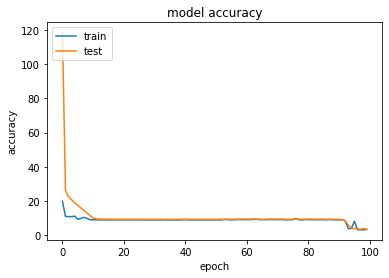

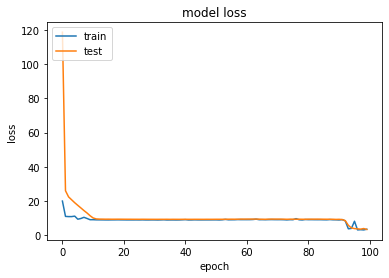

In [61]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

1.3202867395846738
1.2282456084639513
98.37454848569047


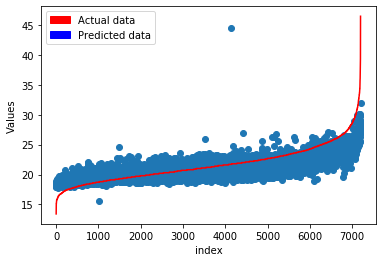

,t + 1,pred (t +1),diff
2419,13.4,18.191751,4.791751
2464,15.0,17.902821,2.902821
1788,15.0,18.570789,3.570789
2690,15.1,18.881800,3.781800
5780,15.1,18.492310,3.392310
2730,15.2,18.174953,2.974953
3299,15.4,18.548992,3.148992
2230,15.4,17.965977,2.565977
1692,15.5,18.641792,3.141792
1494,15.6,17.876085,2.276085


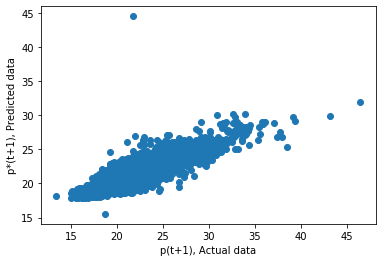

In [63]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)